In [41]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install seaborn --upgrade

In [42]:
import pandas as pd
df = pd.read_csv("//content//IMDB Dataset.csv")

In [43]:
df['label'] = (df['sentiment'] == 'positive').astype(int)

In [44]:
df.head()

,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [45]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
 2   label      50000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


,0
review,0
sentiment,0
label,0


In [46]:
df['sentiment'].value_counts()

,count
sentiment,
positive,25000
negative,25000


# Dataset Analysis

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

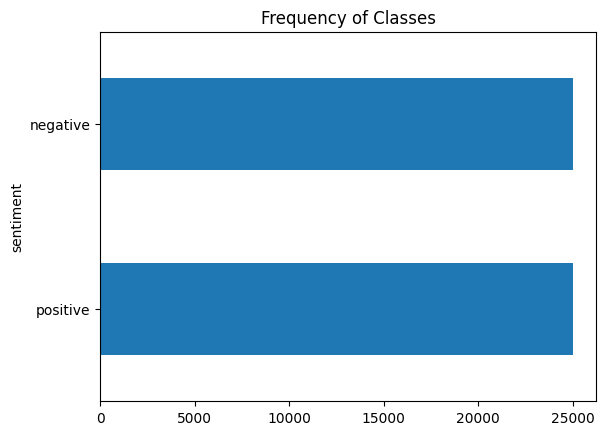

In [48]:
label_counts = df['sentiment'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.show()

<Axes: title={'center': 'Words per Review'}, xlabel='sentiment'>

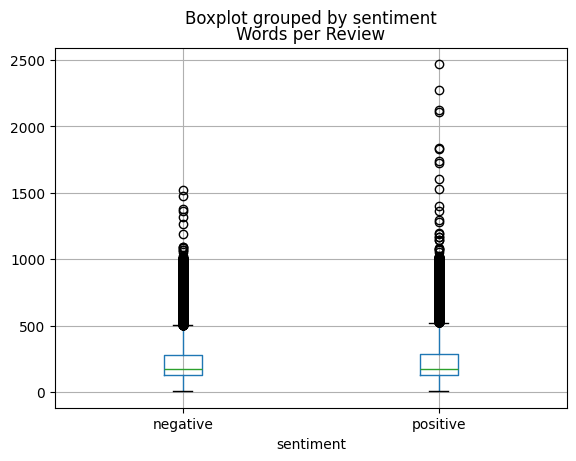

In [49]:
df['Words per Review'] = df['review'].str.split().apply(len)
df.boxplot("Words per Review", by="sentiment")

#Text to Token Conversion

In [50]:
from transformers import AutoTokenizer

In [51]:
model_ckpt = "bert-base-uncased"  #ENGLISH english
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

text = "We love to sleep! Winters are awesome!"
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 2057, 2293, 2000, 3637, 999, 12214, 2024, 12476, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [52]:
len(tokenizer.vocab), tokenizer.vocab_size, tokenizer.model_max_length

(30522, 30522, 512)

# Data Loader and Train Test Split

In [53]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, stratify=df['sentiment'])
test, validation = train_test_split(test, test_size=1/3, stratify=test['sentiment'])
train.shape, test.shape, validation.shape

((35000, 4), (10000, 4), (5000, 4))

In [54]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict({
    "train": Dataset.from_pandas(train, preserve_index=False),
    "test": Dataset.from_pandas(test, preserve_index=False),
    "validation": Dataset.from_pandas(validation, preserve_index=False)
})

In [55]:
dataset

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment', 'label', 'Words per Review'],
        num_rows: 35000
    })
    test: Dataset({
        features: ['review', 'sentiment', 'label', 'Words per Review'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['review', 'sentiment', 'label', 'Words per Review'],
        num_rows: 5000
    })
})

#Tokenization of emotion/sentiment data

In [56]:
dataset['train'][0]

{'review': 'If you want to see a true thriller, rent this!!! It\'s not from the director or screenwriter of "Scream", doesn\'t feature overacting, overpaid "TV" actors passing off as "stars", and is not a run of the mill special effects bonanza. Instead you\'ll get a top-notch, edgy, very strong (in violence) yet thrilling nailbiter.',
 'sentiment': 'positive',
 'label': 1,
 'Words per Review': 53}

In [57]:
def tokenize(batch):
    temp = tokenizer(batch['review'], padding=True, truncation=True, return_token_type_ids=True,)
    return temp

print(tokenize(dataset['train'][0]))

{'input_ids': [101, 2065, 2017, 2215, 2000, 2156, 1037, 2995, 10874, 1010, 9278, 2023, 999, 999, 999, 2009, 1005, 1055, 2025, 2013, 1996, 2472, 2030, 11167, 1997, 1000, 6978, 1000, 1010, 2987, 1005, 1056, 3444, 2058, 18908, 2075, 1010, 2058, 4502, 3593, 1000, 2694, 1000, 5889, 4458, 2125, 2004, 1000, 3340, 1000, 1010, 1998, 2003, 2025, 1037, 2448, 1997, 1996, 4971, 2569, 3896, 14753, 16076, 1012, 2612, 2017, 1005, 2222, 2131, 1037, 2327, 1011, 18624, 1010, 3968, 6292, 1010, 2200, 2844, 1006, 1999, 4808, 1007, 2664, 26162, 13774, 16313, 2121, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [58]:
emotion_encoded=dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/35000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [59]:
df['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

In [60]:
label2id = {'negative':0, 'positive':1}
id2label = {0:'negative', 1:'positive'}
label2id, id2label

({'negative': 0, 'positive': 1}, {0: 'negative', 1: 'positive'})

#Model Building

In [61]:
from transformers import AutoModel
import torch

In [62]:
model = AutoModel.from_pretrained(model_ckpt)

In [63]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [64]:
model.config
model_two="bert-base-cased"

In [65]:
from transformers import AutoModelForSequenceClassification, AutoConfig
Num_labels = len(label2id)
device = torch.device ("cuda" if torch. cuda.is_available() else "cpu")
config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [66]:
device

device(type='cuda')

In [67]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [74]:
from transformers import TrainingArguments

batch_size=16
training_dir = "bert_base_training_dir"
training_args= TrainingArguments(output_dir = training_dir,
              overwrite_output_dir = True,
              num_train_epochs = 1,
              learning_rate = 2e-5,
              per_device_train_batch_size = batch_size,
              per_device_eval_batch_size = batch_size,
              weight_decay = 0.01,
              evaluation_strategy = 'epoch',
              disable_tqdm = False
    )

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [69]:
!pip install evaluate

other than the above method, you can also use sklearn to calc accuracy

In [70]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics (pred) :
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

#Build Model and Trainer

In [75]:
from transformers import Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=emotion_encoded['train'],
    eval_dataset=emotion_encoded['validation'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

<ipython-input-75-f7f22c6f6a80>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [72]:
emotion_encoded['train'][0]

{'review': 'If you want to see a true thriller, rent this!!! It\'s not from the director or screenwriter of "Scream", doesn\'t feature overacting, overpaid "TV" actors passing off as "stars", and is not a run of the mill special effects bonanza. Instead you\'ll get a top-notch, edgy, very strong (in violence) yet thrilling nailbiter.',
 'sentiment': 'positive',
 'label': 1,
 'Words per Review': 53,
 'input_ids': [101,
  2065,
  2017,
  2215,
  2000,
  2156,
  1037,
  2995,
  10874,
  1010,
  9278,
  2023,
  999,
  999,
  999,
  2009,
  1005,
  1055,
  2025,
  2013,
  1996,
  2472,
  2030,
  11167,
  1997,
  1000,
  6978,
  1000,
  1010,
  2987,
  1005,
  1056,
  3444,
  2058,
  18908,
  2075,
  1010,
  2058,
  4502,
  3593,
  1000,
  2694,
  1000,
  5889,
  4458,
  2125,
  2004,
  1000,
  3340,
  1000,
  1010,
  1998,
  2003,
  2025,
  1037,
  2448,
  1997,
  1996,
  4971,
  2569,
  3896,
  14753,
  16076,
  1012,
  2612,
  2017,
  1005,
  2222,
  2131,
  1037,
  2327,
  1011,
  18624,

In [76]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.190700,0.169572,0.940800,0.940798


TrainOutput(global_step=2188, training_loss=0.19903618064615364, metrics={'train_runtime': 3519.348, 'train_samples_per_second': 9.945, 'train_steps_per_second': 0.622, 'total_flos': 9208886937600000.0, 'train_loss': 0.19903618064615364, 'epoch': 1.0})

In [77]:
preds_output = trainer.predict(emotion_encoded[ 'test'])
preds_output.metrics

{'test_loss': 0.17622189223766327,
 'test_accuracy': 0.9403,
 'test_f1': 0.9402983229798925,
 'test_runtime': 299.1314,
 'test_samples_per_second': 33.43,
 'test_steps_per_second': 2.089}

In [78]:
preds_output.predictions

array([[-2.200334  ,  3.120362  ],
       [-2.1099083 ,  2.892042  ],
       [ 1.9955622 , -2.7546628 ],
       ...,
       [-0.49038658,  1.2497166 ],
       [ 2.6244283 , -3.3190005 ],
       [ 2.3745744 , -3.0694482 ]], dtype=float32)

In [79]:
import numpy as np
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = emotion_encoded['test'][:]['label']

In [80]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      5000
           1       0.94      0.95      0.94      5000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



In [ ]:
label2id

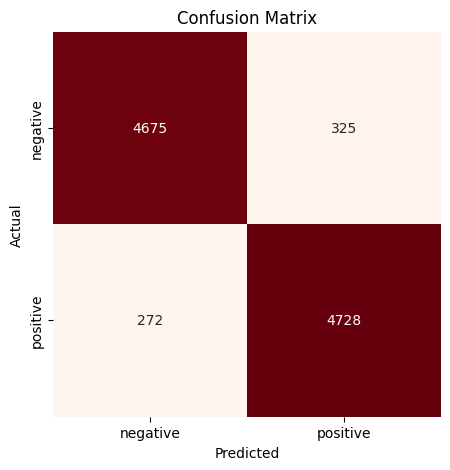

In [82]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, xticklabels=label2id.keys(), yticklabels=label2id.keys(), fmt ='d', cbar=False, cmap='Reds')
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.show()

#Build Prediction function and save model

In [83]:
text = "I am super happy today. I got it done. Finally!!"
def get_prediction (text) :
    input_encoded = tokenizer(text, return_tensors='pt').to(device)
    with torch.no_grad():
      outputs = model(**input_encoded)
    logits = outputs. logits
    pred = torch.argmax(logits, dim=1) .item()
    return id2label[pred]
get_prediction (text)

'positive'

In [84]:
trainer.save_model("bert-base-uncased-sentiment-model")

In [85]:
# use pipeline for prediciton
from transformers import pipeline
classifier = pipeline('text-classification', model= 'bert-base-uncased-sentiment-model')
classifier([text, 'A very good day indeed', "We loved mth111", "I am feeling anxious"])

Device set to use cuda:0


[{'label': 'positive', 'score': 0.9910394549369812},
 {'label': 'positive', 'score': 0.9815585017204285},
 {'label': 'positive', 'score': 0.9279352426528931},
 {'label': 'positive', 'score': 0.8716050982475281}]

In [88]:
classifier = pipeline('sentiment-analysis', model='distilbert-base-uncased')

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Device set to use cuda:0


In [90]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.3 MB/s eta 0:00:00


In [93]:
!pip install streamlit
!pip install pyngrok

In [96]:
from pyngrok import ngrok
import os

ngrok.set_auth_token("2rqYW3PP7adceQbe3DGpoeKp1sY_63TWkfC9QxY2U7ezjqYie")
# Open a ngrok tunnel to the streamlit port 8501
public_url = ngrok.connect(8501)

# Run Streamlit app in the background
os.system("streamlit run app.py &")

# Output the ngrok URL
print(f"Streamlit app is live at: {public_url}")

Streamlit app is live at: NgrokTunnel: "https://730d-35-247-134-17.ngrok-free.app" -> "http://localhost:8501"
